In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import re
import nltk
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier

from wordcloud import WordCloud,STOPWORDS

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('Sentiment.csv')

In [3]:
df.head()

,id,candidate,candidate_confidence,relevant_yn,relevant_yn_confidence,sentiment,sentiment_confidence,subject_matter,subject_matter_confidence,candidate_gold,...,relevant_yn_gold,retweet_count,sentiment_gold,subject_matter_gold,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
0,1,No candidate mentioned,1.0,yes,1.0,Neutral,0.6578,None of the above,1.0000,NaN,...,NaN,5,NaN,NaN,RT @NancyLeeGrahn: How did everyone feel about...,NaN,2015-08-07 09:54:46 -0700,629697200650592256,NaN,Quito
1,2,Scott Walker,1.0,yes,1.0,Positive,0.6333,None of the above,1.0000,NaN,...,NaN,26,NaN,NaN,RT @ScottWalker: Didn't catch the full #GOPdeb...,NaN,2015-08-07 09:54:46 -0700,629697199560069120,NaN,NaN
2,3,No candidate mentioned,1.0,yes,1.0,Neutral,0.6629,None of the above,0.6629,NaN,...,NaN,27,NaN,NaN,RT @TJMShow: No mention of Tamir Rice and the ...,NaN,2015-08-07 09:54:46 -0700,629697199312482304,NaN,NaN
3,4,No candidate mentioned,1.0,yes,1.0,Positive,1.0000,None of the above,0.7039,NaN,...,NaN,138,NaN,NaN,RT @RobGeorge: That Carly Fiorina is trending ...,NaN,2015-08-07 09:54:45 -0700,629697197118861312,Texas,Central Time (US & Canada)
4,5,Donald Trump,1.0,yes,1.0,Positive,0.7045,None of the above,1.0000,NaN,...,NaN,156,NaN,NaN,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,NaN,2015-08-07 09:54:45 -0700,629697196967903232,NaN,Arizona


In [4]:
df.columns

Index(['id', 'candidate', 'candidate_confidence', 'relevant_yn',
       'relevant_yn_confidence', 'sentiment', 'sentiment_confidence',
       'subject_matter', 'subject_matter_confidence', 'candidate_gold', 'name',
       'relevant_yn_gold', 'retweet_count', 'sentiment_gold',
       'subject_matter_gold', 'text', 'tweet_coord', 'tweet_created',
       'tweet_id', 'tweet_location', 'user_timezone'],
      dtype='object')

In [5]:
#selecting only important columns
df = df[['text','sentiment']]

In [6]:
df.head(10)

,text,sentiment
0,RT @NancyLeeGrahn: How did everyone feel about...,Neutral
1,RT @ScottWalker: Didn't catch the full #GOPdeb...,Positive
2,RT @TJMShow: No mention of Tamir Rice and the ...,Neutral
3,RT @RobGeorge: That Carly Fiorina is trending ...,Positive
4,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,Positive
5,"RT @GregAbbott_TX: @TedCruz: ""On my first day ...",Positive
6,RT @warriorwoman91: I liked her and was happy ...,Negative
7,Going on #MSNBC Live with @ThomasARoberts arou...,Neutral
8,Deer in the headlights RT @lizzwinstead: Ben C...,Negative
9,RT @NancyOsborne180: Last night's debate prove...,Negative


In [7]:
df.tail(10)

,text,sentiment
13861,RT @RWSurferGirl: Why should @realDonaldTrump ...,Negative
13862,"RT @RWSurferGirl: Trump has got it right, nobo...",Positive
13863,So trans soldiers can die for you Huckabee but...,Negative
13864,RT @RWSurferGirl: Is it just me or does anyone...,Negative
13865,RT @RWSurferGirl: Fox is cherry picking the ca...,Negative
13866,RT @cappy_yarbrough: Love to see men who will ...,Negative
13867,RT @georgehenryw: Who thought Huckabee exceede...,Positive
13868,"RT @Lrihendry: #TedCruz As President, I will a...",Positive
13869,RT @JRehling: #GOPDebate Donald Trump says tha...,Negative
13870,RT @Lrihendry: #TedCruz headed into the Presid...,Positive


In [8]:
df.shape

(13871, 2)

In [9]:
df.sentiment.unique()

array(['Neutral', 'Positive', 'Negative'], dtype=object)

In [11]:
df.sample(10)

,text,sentiment
11994,"RT @RWSurferGirl: Thanks Fox News, you're rais...",Positive
1024,RT @bmangh: #GOPDebate was like #JackNicholson...,Negative
1179,They were treating lives as pawns.\n\nPolices ...,Negative
13290,RT @mozgovaya: 10 men on stage discussing one ...,Negative
5070,Just finished the #GOPDebate. Two hours of exc...,Negative
6191,That awkward moment when you realize Trump is ...,Negative
7699,"""Women shouldn't have body rights.""\n""Oh, yeah...",Negative
7244,"RT @rabiasquared: Are you there God? It's me, ...",Neutral
7619,RT @APechtold: Dominant thema #GOPDebate ... A...,Negative
8895,"Overall view on #GOPDebates...\n\n""I stayed ho...",Positive


Visualizing tweets in Word Cloud

In [12]:
def cleanedWords(tweet):
    tweet=tweet.replace("RT","")
    tweet=re.sub("@\w+:?", "",tweet)
    letters = re.sub("[^a-zA-Z]", " ",tweet)
    words = letters.lower().split()                            
    stops = set(stopwords.words("english"))                  
    important_words = [w for w in words
                       if 'http' not in w
                       and w not in ["gopdebate","gopdebates"]
                       and w not in stops]
    return important_words

In [13]:
def getWordCloud(tweet,sentiment):
    data=tweet[tweet['sentiment'] == sentiment]
    words = ' '.join(data['text'])
    cleaned_word = " ".join(cleanedWords(words))
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     )
    wordcloud.generate(cleaned_word)
    plt.figure(1,figsize=(12, 12))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

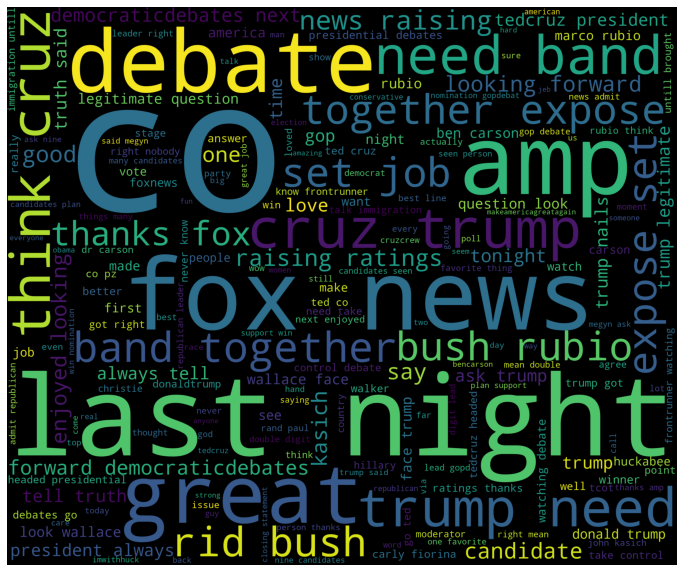

In [14]:
getWordCloud(df,'Positive')

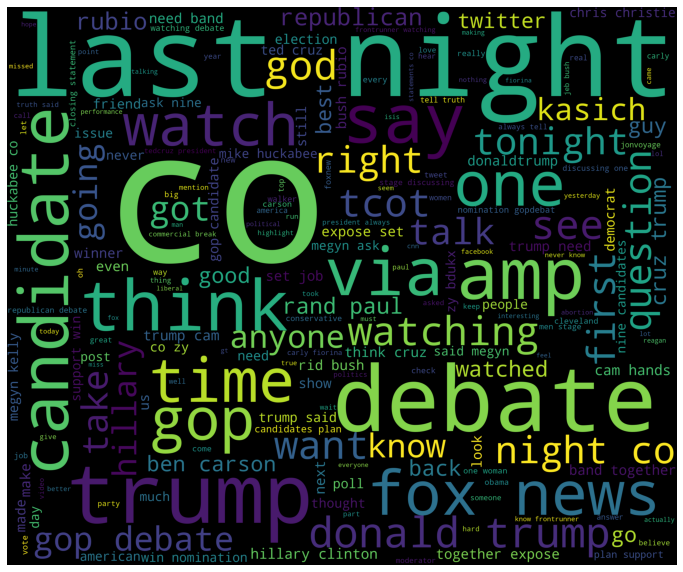

In [16]:
getWordCloud(df,'Neutral')

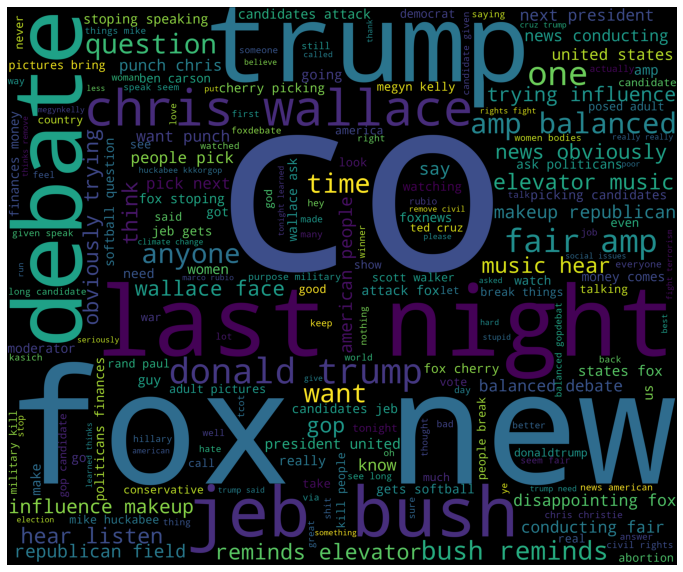

In [17]:
getWordCloud(df,'Negative')

In [18]:
def tweet_to_words(tweet):
    return( " ".join( cleanedWords(tweet)))

In [19]:
df['clean_tweet']=df['text'].apply(lambda x: tweet_to_words(x))

In [20]:
df[['clean_tweet','text']].head()

,clean_tweet,text
0,everyone feel climate change question last nig...,RT @NancyLeeGrahn: How did everyone feel about...
1,catch full last night scott best lines seconds...,RT @ScottWalker: Didn't catch the full #GOPdeb...
2,mention tamir rice held cleveland wow,RT @TJMShow: No mention of Tamir Rice and the ...
3,carly fiorina trending hours debate men comple...,RT @RobGeorge: That Carly Fiorina is trending ...
4,w delivered highest ratings history presidenti...,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...


In [21]:
train,test = train_test_split(df,test_size = 0.1,random_state=42)

In [22]:
from sklearn.feature_extraction.text import CountVectorizer
v = CountVectorizer(analyzer = 'word' )

In [23]:
train_features= v.fit_transform(train['clean_tweet'].values)
test_features=v.transform(test['clean_tweet'].values)

In [24]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

In [25]:
model = logreg.fit(train_features,train['sentiment'])
pred = model.predict(test_features)
accuracy = accuracy_score(test['sentiment'],pred)

In [26]:
accuracy

0.6829971181556196

In [27]:
from sklearn.metrics import classification_report

In [28]:
print(classification_report(test['sentiment'],pred))

              precision    recall  f1-score   support

    Negative       0.75      0.85      0.80       846
     Neutral       0.50      0.37      0.42       308
    Positive       0.58      0.49      0.53       234

    accuracy                           0.68      1388
   macro avg       0.61      0.57      0.58      1388
weighted avg       0.66      0.68      0.67      1388

